# Загрузка Pandas и очистка данных

In [1]:
# PROD
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import collections as cl
from datetime import datetime
from math import radians, sin, cos, asin, sqrt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import warnings
from scipy.stats import norm
import itertools as it

%matplotlib inline

In [ ]:
# Restaurant_id — идентификационный номер ресторана / сети ресторанов;
# City — город, в котором находится ресторан;
# Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
# Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
# Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
# Price Range — диапазон цен в ресторане;
# Number of Reviews — количество отзывов о ресторане;
# Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
# URL_TA — URL страницы ресторана на TripAdvosor;
# ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [2]:
# PROD
df_basic = pd.read_csv('main_task.csv')
### Добавляем в Датасет значения из соревнования
df_kggl = pd.read_csv('kaggle_task.csv')
# Дополнительный ДатаСет с Кэггле
df_add = pd.read_csv('TA_restaurants_curated.csv')

In [3]:
# PROD
# Датафрейм по численности населения в городах
df_cities = pd.read_csv('worldcities.csv')

In [ ]:
df_basic.info()

In [ ]:
df_kggl.info()

In [ ]:
df_add.info()

In [4]:
# PROD
df_add.drop(df_add[(df_add.Ranking.isna())|(df_add.Rating.isna())].index, axis = 0, inplace = True)

In [5]:
# PROD
df_basic['source'] = 'basic'
df_add['source'] = 'add'
df_kggl['source'] = 'kggl'

### Проверка Датасетов на пересечение. Объединение

In [ ]:
# Проверка пересечения: нахожу пересекающиеся ИДшники и проверяю полные дубликаты по ним
result_ids_basic_add = (set(df_add.ID_TA)).intersection(set(df_basic.ID_TA))
len(result_ids_basic_add)

In [ ]:
result_ids_kggl_add = (set(df_add.ID_TA)).intersection(set(df_kggl.ID_TA))
len(result_ids_kggl_add)

In [ ]:
df_basic.columns

In [ ]:
df1_add_kggl = df_add[['City', 'Cuisine Style', 'Ranking',
       'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'source', 'Restaurant_id']].loc[df_add.ID_TA.isin(result_ids_basic_add)]

In [ ]:
df1_add = df_add[['City', 'Cuisine Style', 'Ranking', 'Rating',
       'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'source', 'Restaurant_id']].loc[df_add.ID_TA.isin(result_ids_basic_add)]

In [ ]:
df1_basic = df_basic[['City', 'Cuisine Style', 'Ranking', 'Rating',
       'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'source', 'Restaurant_id']].loc[df_basic.ID_TA.isin(result_ids_basic_add)]

In [ ]:
df1_kggl = df_kggl[['City', 'Cuisine Style', 'Ranking',
       'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'source', 'Restaurant_id']].loc[df_kggl.ID_TA.isin(result_ids_kggl_add)]

In [ ]:
# объединение исходного и расширенного + удаление дубликатов из них
len(pd.concat([df1_basic, df1_add], axis = 0))

In [ ]:
len(pd.concat([df1_basic, df1_add], axis = 0).drop_duplicates(subset=['ID_TA'], keep='first'))

In [ ]:
# Разница между исходным и объединенным - в 96 значений. Просто сократим список сверяемых значений при удалении дубликатов и выкинем значения из расширенного столбца
basic_add_vc = pd.concat([df1_basic.drop_duplicates(subset=['ID_TA'], keep='last'), df1_add], axis = 0).drop_duplicates(subset=['ID_TA'], keep='first')['source'].value_counts()

In [ ]:
# Объекдинение расширенного и тестового датасетов, поиск пересечения

len(pd.concat([df1_kggl, df1_add_kggl], axis = 0))

In [ ]:
len(pd.concat([df1_kggl, df1_add_kggl], axis = 0).drop_duplicates(subset=['ID_TA'], keep='first'))

In [ ]:
kggl_add_vc = pd.concat([df1_kggl, df1_add_kggl], axis = 0).drop_duplicates(subset=['ID_TA'], keep='first')['source'].value_counts()

In [ ]:
### Объединяем по ID_TA в приоритете оставляя строки из задания и из тестовой выборки

In [6]:
# PROD
df_basic_con = df_basic[['City', 'Cuisine Style', 'Ranking', 'Rating',
       'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'source', 'Restaurant_id']]
df_kggl['Rating'] = -1
df_kggl_con = df_kggl[['City', 'Cuisine Style', 'Ranking', 'Rating',
       'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'source', 'Restaurant_id']]
df_add_con = df_add[['City', 'Cuisine Style', 'Ranking', 'Rating',
       'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'source', 'Restaurant_id']]
print(len(df_basic_con), len(df_kggl_con), len(df_add_con))

40000 10000 115751


In [7]:
# PROD
df_basic_kggl = pd.concat([df_basic_con.drop_duplicates(subset = ['ID_TA'], keep='last'), df_kggl_con], axis = 0).drop_duplicates(subset=['ID_TA'], keep='last')

In [8]:
# PROD
# Проверитьсколько значений осталось из исходного датасета!!!
df_basic_kggl.source.value_counts()

basic    39963
kggl     10000
Name: source, dtype: int64

In [9]:
# PROD
df = pd.concat([df_basic_kggl, df_add_con.drop_duplicates(subset = ['ID_TA'], keep='last')], axis = 0).drop_duplicates(subset=['ID_TA'], keep='first')

In [ ]:
# PROD
# Проверитьсколько значений осталось из исходного датасета
df.source.value_counts()

In [ ]:
# для проверки совпадают ли значений в ссылках URL_TA со значениями ID_TA. Чтобы понять, можно ли удалять дубликаты
def real_id(link):
    pattern_id=re.compile('d[0-9]+')
    return pattern_id.search(link)[0]

In [ ]:
df.info()

In [10]:
# PROD
# В расширенном Датасете df_add оказались пустые значения в отзывах (порядка 8 тысяч). Это ошибка данных, т.к. по данному городу у других ресторанов значения есть
df.Reviews.fillna('[[], []]', inplace=True)

In [ ]:
# Достаточно много пропусков. Причем в основном в Датасете _add

#### Изучение значений в Датафрейме

In [11]:
# PROD
df.columns = [ 'city', 'cuisine_style', 'ranking', 'rating',
       'price_range', 'number_of_reviews', 'reviews', 'URL_TA', 'ID_TA', 'source', 'restaurant_id']

In [12]:
# PROD
# Список городов
cities = df.city.unique()

In [13]:
# PROD
# Замена названия города на название в датафрейме по населению
cities[5]='Porto'

In [14]:
# PROD
df.city[df.city == 'Oporto'] = 'Porto'

#### Заполянем пропуски с кухнях
#### Основная идея - это два пути: попробовать заполнить значением other и самыми популярными кухнями в городе топ-ом среднего кол-ва кухонь в ресторане города

In [15]:
# PROD
df['cuisine_style_other'] = df['cuisine_style'].fillna('other')

In [16]:
# PROD
# очищаем строки с наименованиями кухонь, преобразовываем в список
df['cuisine_style_other']=df['cuisine_style_other'].str.replace('[','').str.replace(']','').str.replace('''''','').str.split(', ')

In [17]:
# PROD
def cuisine_to_counter(lst):
    cuisine_counter = cl.Counter()
    for cuisine in lst:
        if cuisine == 'other':
            continue
        else:
            cuisine_counter[cuisine]+=1
    return cuisine_counter

In [18]:
# PROD
df['cuisine_style_counter']=df['cuisine_style_other'].apply(cuisine_to_counter)

In [19]:
# PROD
# подсчет кол-ва кухонь по типам в городе
cuisine_by_city = df.loc[df.cuisine_style.isna()!=True].groupby(['city'])['cuisine_style_counter'].sum()

In [20]:
# PROD
cuisine_number_in_city = {}
for city in set(df.city):
    cuisine_number_in_city_params = {}
    cuisine_number_in_city_params['mean'] = round(df.loc[(df['city']==city) & (df.cuisine_style.isna()!=True)].cuisine_style_counter.apply(len).mean(), 8)
    cuisine_number_in_city_params['med'] = df.loc[(df['city']==city) & (df.cuisine_style.isna()!=True)].cuisine_style_counter.apply(len).median()
    cuisine_number_in_city_params['mode'] = df.loc[(df['city']==city) & (df.cuisine_style.isna()!=True)].cuisine_style_counter.apply(len).value_counts().idxmax()
    cuisine_number_in_city[city] = cuisine_number_in_city_params
    

In [ ]:
# Словарь с мерами среднего по кол-ву кухонь
cuisine_number_in_city

In [21]:
# PROD
stat_list = ['mean', 'med', 'mode']

In [22]:
# PROD
def cuisine_index_in_city(stat, counter, city):
    cuisine_number=int(cuisine_number_in_city[city][stat])
    index=0
    if len(counter)==0:
        for item in cuisine_by_city[city].most_common(cuisine_number):
            index+=item[1]
        return index
    else:
        for item in list(counter):
            index+=cuisine_by_city[city][item]
        return index

In [23]:
# PROD
# кол-во кухонь в ресторане с вариативностью по статистике
def cuisine_number(stat, counter, city):
    cuisine_number=(cuisine_number_in_city[city][stat])
    if len(counter)==0:
        return cuisine_number
    else:
        return len(counter)

In [24]:
# PROD
# Добавляем колонку с суммарным индексом популярности кухни ресторана в городе
for stat in stat_list:
    df['cuisine_index_'+stat] = df.apply(lambda x: cuisine_index_in_city(stat, x['cuisine_style_counter'], x['city']), axis = 1)

In [25]:
# PROD
# Добавляем колонку с кол-вом кухонь в ресторане
for stat in stat_list:
    df['cuisine_number_'+stat] = df.apply(lambda x: cuisine_number(stat, x['cuisine_style_counter'], x['city']), axis = 1)

In [ ]:
# Нормализация значений суммарного индекса популярности кухонь в городе
# По-настоящему Нормализовать в итоге не буду, т.к. RF нечувствителен к нормализации

In [26]:
# PROD
# словарь с мин и макс значнеиями для нормализации по городу
dic_norm_city_cuisine = {}
for city in cities:
    dic_norm_cuisine_params ={}
    for stat in stat_list:
        dic_norm_cuisine_params_stat={}
        max = df.loc[df.city==city]['cuisine_index_'+stat].max()
        min = df.loc[df.city==city]['cuisine_index_'+stat].min()
        dic_norm_cuisine_params_stat['max']=max
        dic_norm_cuisine_params_stat['min']=min
        dic_norm_cuisine_params[stat]=dic_norm_cuisine_params_stat
    dic_norm_city_cuisine[city]=dic_norm_cuisine_params

In [27]:
# PROD
# ручная нормализация
def mm_norm_cuisine_in_city(stat, index, city):
    #ct = df.loc[df.ID_TA==id]['city'].iloc[0]
    #ind = df.loc[df.ID_TA==id]['cuisine_index_mean'].iloc[0]
    max = dic_norm_city_cuisine[city][stat]['max']
    min = dic_norm_city_cuisine[city][stat]['min']
    index_norm = (index - min)/(max-min)
    return index_norm

In [28]:
# PROD
# колонка с нормализованными значениями попоулярности кухни по городу
for stat in stat_list:
    df['cuisine_index_mmnorm_'+stat]=df.apply(lambda x: mm_norm_cuisine_in_city(stat, x['cuisine_index_'+stat], x['city']), axis = 1)

In [30]:
# PROD
# признак наличия-отсутстивя описания кухонь
df['with_cuisine_list']=df['cuisine_style_other'].apply(lambda x: 0 if x[0]=='other' else 1)

#### Обработка Ranking. Основная идея: нормализация внутри города, проверка на выбросы

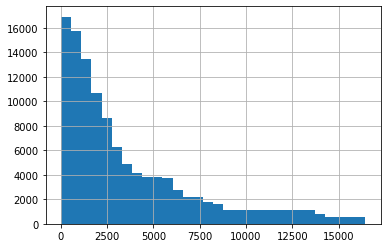

In [31]:
# PROD
df['ranking'].hist(bins=30)

##### Выбросов не видно. Все вроде в рамках здравого смысла

In [ ]:
# Предположительно, что у совсем новых ресторанов рейтинг низкий - еще не успел накопиться

In [ ]:
#df[['ranking', 'ranking_mmnorm','ID_TA']].loc[df.ranking<38]
# предположение неверное

In [32]:
# PROD
dic_norm_city_ranking = {}
for city in cities:
    dic_norm_city_ranking[city]=df.loc[df.city==city]['ranking'].max()

In [33]:
# PROD
def norm_ranking_in_city(ranking, city):
    max = dic_norm_city_ranking[city]
    rank_norm = ranking/max
    return rank_norm

In [34]:
# PROD
df['ranking_norm']=df.apply(lambda x: norm_ranking_in_city(x['ranking'], x['city']), axis = 1)

###### Здесь было проведено логарифмирование и взятие квадратного корня признаков, но это для RF не должно влиять

#### price_range. Основные действия: заполнить пропуски средним, преобразовать в числа, сделать get_dummies

In [35]:
# PROD
df['price_to_digit'] = df['price_range'].fillna(-1).apply(lambda x: x if x==-1 else 1 if x=='$' else 2 if x.replace(' - ', '-')=='$$-$$$' else 3)

In [ ]:
# возвращает вместо пустых значения статисттику по городу

In [36]:
# PROD
# Словарь со средними значением цен по городам
dic_price_city={}
for city in cities:
    dic_price_city_stat={}
    dic_price_city_stat['mean'] = df.loc[(df.price_to_digit>0) & (df.city==city)]['price_to_digit'].mean()
    dic_price_city_stat['med'] = df.loc[(df.price_to_digit>0) & (df.city==city)]['price_to_digit'].median()
    dic_price_city_stat['mode'] = df.loc[(df.price_to_digit>0) & (df.city==city)]['price_to_digit'].mode().iloc[0]
    dic_price_city[city]=dic_price_city_stat

In [38]:
# PROD
# возвращает среднее значение по городу по ценовой категории
def price_city(stat, city, price):
    if price == -1:
        return dic_price_city[city][stat]
    else:
        return price

In [39]:
# PROD
for stat in stat_list:
    df['digit_price_'+stat] = df.apply(lambda x: price_city(stat, x['city'], x['price_to_digit']), axis = 1)

In [40]:
# PROD
df['with_price'] = df['price_to_digit'].apply(lambda x: 0 if x==-1 else 1)

##### Здесь была проверка на выбросы, но для RF это несущественно

In [41]:
# PROD
# признак отсутствия значения кол-ва отзывов
df['with_number_of_reviews']=pd.isna(df.number_of_reviews).astype('uint8').apply(lambda x: 0 if x==1 else 1)

In [42]:
# PROD
dic_number_of_reviews_city={}
for city in cities:
    dic_number_of_reviews_city_stat={}
    dic_number_of_reviews_city_stat['mean'] = df.loc[(df.with_number_of_reviews==1) & (df.city==city)]['number_of_reviews'].mean()
    dic_number_of_reviews_city_stat['med'] = df.loc[(df.with_number_of_reviews==1) & (df.city==city)]['number_of_reviews'].median()
    dic_number_of_reviews_city_stat['mode'] = df.loc[(df.with_number_of_reviews==1) & (df.city==city)]['number_of_reviews'].mode().iloc[0]
    dic_number_of_reviews_city[city]=dic_number_of_reviews_city_stat

In [43]:
# PROD
# возвращает среднее значение по городу по кол-во отзывов
def number_of_reviews_city(stat, city, number, with_number):
    if with_number == 0:
        return dic_number_of_reviews_city[city][stat]
    else:
        return number

In [44]:
# PROD
for stat in stat_list:
    df['number_of_reviews_'+stat] = df.apply(lambda x: number_of_reviews_city(stat, x['city'], x['number_of_reviews'], x['with_number_of_reviews']), axis = 1)

#### Reviews. Определяем пропуски, признак присутствия значения обоих отзывов, вытащить даты последних двух отзывов, длина отзывов, кол-во дней между последними двумя отзывами,  выбросы, как давно был оставлен последний отзыв. Если только один отзыв, то заполнить расстояние между отызвами средним по городу

In [ ]:
# у каждого ресторана минимум 2 отзыва, поэтому наличие только одного текста и даты отзыва - ошибка в данных. Сразу заменим 

In [45]:
# PROD
def reviews_to_list(string):
    return string.replace('[[','').replace(']]','').replace('\'', '\"').split('], [')

def reviews_text(string):
    return reviews_to_list(string)[0]

def reviews_date(string):
    return reviews_to_list(string)[1]

In [46]:
# PROD
df['text_reviews_str']= df.reviews.apply(reviews_text)
df['date_reviews_str']= df.reviews.apply(reviews_date)

In [ ]:
# выделяем даты двух последних отзывов

In [47]:
# PROD
def review_text_to_date(str):
    datetext_ls=[]
    pattern_date1=re.compile('[0-9]+/[0-9]+/[0-9]+')
    pattern_date2=re.compile('[0-9]+\.[0-9]+\.[0-9]+')
    pattern_date3=re.compile('[0-9]+-[0-9]+-[0-9]+')
    if pattern_date1.findall(str) !=[]:
        datetext_ls.append(pattern_date1.findall(str))
    elif pattern_date2.findall(str) !=[]:
        datetext_ls.append(pattern_date2.findall(str))
    elif pattern_date3.findall(str) !=[]:
        datetext_ls.append(pattern_date3.findall(str))
    else:
        datetext_ls.append('No date')
    return datetext_ls

In [48]:
# PROD
def format_date_list(ls):
    res_ls=[]
    string_date=''
    for list in ls:
        if 'No date' in list:
            res_ls.append('No date')
            continue
        else:
            for item in list:
                if '.' in item:
                    string_date=item.str.replace('.', '/')
                    #print(string_date)
                    res_ls.append(datetime.strptime(string_date, '%m/%d/%Y').date())
                elif '-' in item:
                    string_date=item.str.replace('-', '/')
                    res_ls.append(datetime.strptime(string_date, '%m/%d/%Y').date())
                else:
                    res_ls.append(datetime.strptime(item, '%m/%d/%Y').date())
    return res_ls

In [49]:
# PROD
df['reviews_date'] = df['date_reviews_str'].apply(review_text_to_date)

In [50]:
# PROD
df['date_reviews_date'] = df.reviews_date.apply(format_date_list)

In [51]:
# PROD
df['with_last_reviews'] = df['date_reviews_date'].apply(lambda x: 0 if x[0]=='No date' else len(x))

In [52]:
# PROD
# Дней между последними двумя отзывами
def interval_days(list):
    if len(list)<2:
        return -1
    else:
        return abs((list[0] - list[1]).days)

In [53]:
# PROD
# месяцев между последними двумя отзывами
def interval_month(list):
    if len(list)<2:
        return -1
    else:
        return abs((list[0] - list[1]).days)/30.4167

In [54]:
# PROD
df['days_between_reviews']=df.date_reviews_date.apply(interval_days)

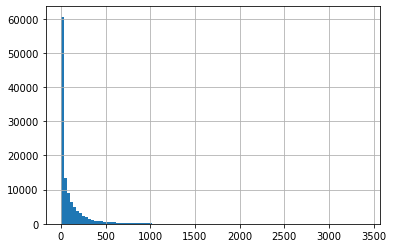

In [55]:
df['days_between_reviews'].hist(bins = 100)

In [56]:
# PROD
df['month_between_reviews']=df.date_reviews_date.apply(interval_month)

In [ ]:
df['month_between_reviews'].hist(bins=100)

In [57]:
# PROD
dic_days_between_reviews_city={}
for city in cities:
    dic_days_between_reviews_city_stat = {}
    dic_days_between_reviews_city_stat['mean'] = df.loc[(df.with_last_reviews==2) & (df.city==city)]['days_between_reviews'].mean()
    dic_days_between_reviews_city_stat['med'] = df.loc[(df.with_last_reviews==2) & (df.city==city)]['days_between_reviews'].median()
    dic_days_between_reviews_city_stat['mode'] = df.loc[(df.with_last_reviews==2) & (df.city==city)]['days_between_reviews'].mode().iloc[0]
    dic_days_between_reviews_city[city]=dic_days_between_reviews_city_stat

In [58]:
# PROD
# возвращает статистику по городу по расстоянию в днях между последними двумя отзывами
def days_between_reviews_city(stat, city, with_last_reviews, days_between_reviews):
    if with_last_reviews < 2:
        return dic_days_between_reviews_city[city][stat]
    else:
        return days_between_reviews

In [59]:
# PROD
for stat in stat_list:
    df['days_between_reviews_'+stat] = df.apply(lambda x: days_between_reviews_city(stat, x.city, x.with_last_reviews, x.days_between_reviews), axis = 1)

In [60]:
# PROD
dic_month_between_reviews_city={}
for city in cities:
    dic_month_between_reviews_city_stat = {}
    dic_month_between_reviews_city_stat['mean'] = df.loc[(df.with_last_reviews==2) & (df.city==city)]['month_between_reviews'].mean()
    dic_month_between_reviews_city_stat['med'] = df.loc[(df.with_last_reviews==2) & (df.city==city)]['month_between_reviews'].median()
    dic_month_between_reviews_city_stat['mode'] = df.loc[(df.with_last_reviews==2) & (df.city==city)]['month_between_reviews'].mode().iloc[0]
    dic_month_between_reviews_city[city]=dic_month_between_reviews_city_stat

In [61]:
# PROD
# возвращает статистику значение по городу по расстоянию в месяцах между последними двумя отзывами
def month_between_reviews_city(stat, city, with_last_reviews, month_between_reviews):
    if with_last_reviews < 2:
        return dic_month_between_reviews_city[city][stat]
    else:
        return month_between_reviews

In [62]:
# PROD
for stat in stat_list:
    df['month_between_reviews_'+stat] = df.apply(lambda x: month_between_reviews_city(stat, x.city, x.with_last_reviews, x.month_between_reviews), axis = 1)

In [63]:
# PROD
def max_date(lst):
    if lst[0]>lst[1]:
        return lst[0]
    else:
        return lst[1]

In [64]:
# PROD
# Расстояние в днях от даты последнего отзыв до сегодня
def days_to_today(list):
    if len(list)<2:
        return -1
    else:
        return (datetime.today().date() - max_date(list)).days

In [65]:
# PROD
df['days_after_last_review']=df.date_reviews_date.apply(days_to_today)

In [66]:
# PROD
dic_days_after_review_city={}
for city in cities:
    dic_days_after_review_city_stat = {}
    dic_days_after_review_city_stat['mean'] = df.loc[(df.with_last_reviews==2) & (df.city==city)]['days_after_last_review'].mean()
    dic_days_after_review_city_stat['med'] = df.loc[(df.with_last_reviews==2) & (df.city==city)]['days_after_last_review'].median()
    dic_days_after_review_city_stat['mode'] = df.loc[(df.with_last_reviews==2) & (df.city==city)]['days_after_last_review'].mode().iloc[0]
    dic_days_after_review_city[city]=dic_days_after_review_city_stat

In [67]:
# PROD
# возвращает среднее значение по городу по расстоянию в месяцах между последними двумя отзывами
def days_after_review_city(stat, city,with_last_reviews, days_after_last_review):
    if with_last_reviews < 2:
        return dic_days_after_review_city[city][stat]
    else:
        return days_after_last_review

In [68]:
# PROD
for stat in stat_list:
    df['days_after_review_'+stat] = df.apply(lambda x: days_after_review_city(stat, x.city, x.with_last_reviews, x.days_after_last_review), axis = 1)

In [69]:
# PROD
# Добавляем признаки глобально по всему датасету, а не по городу
dic_days_after_review_global={}
for stat in stat_list:
    dic_days_after_review_global['mean'] = df.loc[(df.with_last_reviews==2)]['days_after_last_review'].mean()
    dic_days_after_review_global['med'] = df.loc[(df.with_last_reviews==2)]['days_after_last_review'].median()
    dic_days_after_review_global['mode'] = df.loc[(df.with_last_reviews==2)]['days_after_last_review'].mode().iloc[0]

In [70]:
# PROD
def days_after_review_global(stat, with_last_reviews, days_after_last_review):
    if with_last_reviews < 2:
        return dic_days_after_review_global[stat]
    else:
        return days_after_last_review

In [71]:
# PROD
for stat in stat_list:
    df['days_after_review_global_'+stat] = df.apply(lambda x: days_after_review_global(stat, x.with_last_reviews, x.days_after_last_review), axis = 1)

In [72]:
# PROD
# Расстояние в днях от даты последнего отзыв до сегодня
def month_to_today(list):
    if len(list)<2:
        return -1
    else:
        return ((datetime.today().date() - max_date(list)).days)/30.4167

In [73]:
# PROD
df['month_after_last_review']=df.date_reviews_date.apply(month_to_today)

In [74]:
# PROD
dic_month_after_review_city={}
for city in cities:
    dic_month_after_review_city_stat = {}
    dic_month_after_review_city_stat['mean'] = df.loc[(df.with_last_reviews==2) & (df.city==city)]['month_after_last_review'].mean()
    dic_month_after_review_city_stat['med'] = df.loc[(df.with_last_reviews==2) & (df.city==city)]['month_after_last_review'].median()
    dic_month_after_review_city_stat['mode'] = df.loc[(df.with_last_reviews==2) & (df.city==city)]['month_after_last_review'].mode().iloc[0]
    dic_month_after_review_city[city]=dic_month_after_review_city_stat

In [75]:
# PROD
# возвращает среднее значение по городу по расстоянию в месяцах между последними двумя отзывами
def month_after_review_city(stat, city, with_last_reviews, month_after_last_review):
    if with_last_reviews < 2:
        return dic_month_after_review_city[city][stat]
    else:
        return month_after_last_review

In [76]:
# PROD
for stat in stat_list:
    df['month_after_last_review_'+stat] = df.apply(lambda x: month_after_review_city(stat, x.city, x.with_last_reviews, x.month_after_last_review), axis = 1)

In [77]:
# PROD
# Добавляем признаки глобально по всему датасету, а не по городу
dic_month_after_review_global={}
for stat in stat_list:
    dic_month_after_review_global['mean'] = df.loc[(df.with_last_reviews==2)]['month_after_last_review'].mean()
    dic_month_after_review_global['med'] = df.loc[(df.with_last_reviews==2)]['month_after_last_review'].median()
    dic_month_after_review_global['mode'] = df.loc[(df.with_last_reviews==2)]['month_after_last_review'].mode().iloc[0]

In [78]:
# PROD
def month_after_review_global(stat, with_last_reviews, month_after_last_review):
    if with_last_reviews < 2:
        return dic_month_after_review_global[stat]
    else:
        return month_after_last_review

In [79]:
# PROD
for stat in stat_list:
    df['month_after_last_review_global_'+stat] = df.apply(lambda x: month_after_review_global(stat, x.with_last_reviews, x.month_after_last_review), axis = 1)

#### City. Обогащение признаком столичности. Обогащение кол-вом населения

In [80]:
# PROD
dic_number_of_restaurants_by_city={}
for city in cities:
    dic_number_of_restaurants_by_city[city]=df.ranking.loc[df.city == city].max()

In [81]:
# PROD
# Признак кол-во ресторанов на человека начеления
df['number_of_restaurants_per_man'] = df.city.apply(lambda x: dic_number_of_restaurants_by_city[x])

In [82]:
# PROD
dic_cities = {}
for city in cities:
    city_info={}
    info = df_cities[['population', 'capital']].loc[(df_cities.city_ascii==city)&(df_cities.country != 'United States')&(df_cities.country != 'Canada')&(df_cities.country != 'Venezuela')]
    if len(info) == 0:
        continue
    else:
        city_info['population'] = info.population.iloc[0]
        city_info['is_capital'] = info.capital.iloc[0]
    dic_cities[city] = city_info

In [83]:
# PROD
# Не хватает города Порту
df_cities[df_cities.city_ascii=='Porto']
dic_cities['Oporto']={'population': 1337000.0, 'is_capital':'admin'}

In [84]:
# PROD
# Признак столица/не столица
df['is_capital'] = df.city.apply(lambda x: 1 if dic_cities[x]['is_capital'] == 'primary' else 0)

In [85]:
# PROD
# Возвращает кол-во отзывов на одного человека населения города
def reviews_by_population(city, number_of_reviews):
    return number_of_reviews/dic_cities[city]['population']

In [86]:
# PROD
for stat in stat_list:
    df['reviews_by_population_'+stat] = df.apply(lambda x: reviews_by_population(x['city'], x['number_of_reviews_'+stat]), axis = 1)

In [87]:
# PROD
# Возвращает относительный Ranking в зависимости от численности населения
def ranking_by_population(city, ranking):
    return ranking/dic_cities[city]['population']

In [88]:
# PROD
df['ranking_by_population'] = df[['city', 'ranking']].apply(lambda x: ranking_by_population(x.city, x.ranking), axis = 1)

In [89]:
# PROD
# Возвращает относительный Ranking_mmnorm в зависимости от численности населения
def ranking_norm_by_population(city, ranking_norm):
    return ranking_norm/dic_cities[city]['population']

In [90]:
# PROD
df['ranking_norm_by_population'] = df[['city', 'ranking_norm']].apply(lambda x: ranking_norm_by_population(x.city, x.ranking_norm), axis = 1)

In [91]:
# PROD
df['population'] = df.city.apply(lambda x: dic_cities[x]['population'])

### Матрица корреляций

In [ ]:
df.corr()

In [ ]:
corr = df.corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

In [ ]:
# Здесь видна линейная взаимосвязь между признаками, на ее основе можно сделать определенные предположения о причинах связи признаков. Но пытаться однозначно определить взаимосвязь с Рейтингом опасно
# Т.к. для RF линейная зависимость не так важна
# Матрица была использована для генерации новых признаков (микс связанных линейно признаков)]]

#### Dummy- переменные: ценовые категории, города

In [ ]:
# df1 - без dummy по городу

In [92]:
# PROD
dummy_city = pd.get_dummies(df['city'])
df = pd.concat([df,dummy_city],axis = 1)

In [ ]:
# PROD
# Резервная копия
df1=df.copy(deep=True)

In [ ]:
columns_list = list(df.columns)

In [230]:
column_list_for_delete1 = ['ranking',
'city',
 'cuisine_style',
 'price_range',
 'number_of_reviews',
 'reviews',
 'URL_TA',
 'ID_TA',
 'cuisine_style_other',
 'cuisine_style_counter',
 'price_to_digit',
 'text_reviews_str',
 'date_reviews_str',
 'reviews_date',
 'date_reviews_date',
 'days_between_reviews',
 'month_between_reviews',
 'days_after_last_review',
 'month_after_last_review',
'cuisine_index_mmnorm_mean',
'cuisine_index_mmnorm_med',
'cuisine_index_mmnorm_mode']

In [94]:
# Резервная копия
df_copy = df.copy(deep=True)

In [231]:
# df=df_copy.copy(deep=True)

# Удаление колонок

In [232]:
df.drop(column_list_for_delete1, axis=1, inplace=True)

In [212]:
df.source.value_counts()

add      65625
basic    39963
kggl     10000
Name: source, dtype: int64

In [ ]:
# PROD

In [233]:
df_kaggle = df[df.source == 'kggl'].copy(deep=True)

In [234]:
df[df.source == 'kggl'].source.value_counts()

kggl    10000
Name: source, dtype: int64

In [235]:
df = df[df.source != 'kggl'].copy(deep=True)

In [236]:
df.drop(['source', 'restaurant_id'], axis = 1, inplace = True)

In [253]:
df_kaggle.drop(['source'], axis = 1, inplace = True)

In [ ]:
# Определяем, сколько комбинаций будет, когда замиксуем все статистические колонки и норм/ненорм колонки
# От идеи отказался, т.к. комбинаций 300к+
#count = 0
#for list in it.product(*list_of_list):
#    count+=1

In [ ]:
#(it.product(*list_of_list))
#[reviews_by_population_columns, after_last_review_columns, number_of_reviews_columns]

In [237]:
# PROD
full_columns_list = df.columns

In [238]:
# Коллонки со статистиками
list_mean = []
list_med = []
list_mode = []

In [239]:
# PROD
def col_list(stat1, stat2):
    list = []
    for col in full_columns_list:
        if (stat1 not in col) &(stat2 not in col) :
            list.append(col)
    return list

In [240]:
list_mean = col_list('med', 'mode')
list_med = col_list('mean', 'mode')
list_mode = col_list('med', 'mean')

In [241]:
df_mean = df[list_mean]

In [242]:
df_med = df[list_med]

In [243]:
df_mode = df[list_mode]

In [254]:
df_kaggle_mean = df_kaggle[list_mean]

# Фиксируем RANDOM_SEED для воспроизводимости

In [130]:
RS1=42

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [244]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df_mean.drop(['rating'], axis = 1)
y = df_mean['rating']

In [ ]:
#X.info()

In [133]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [245]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 20% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Создаём, обучаем и тестируем модель

In [135]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [246]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, random_state=RS1)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [203]:
# Округление выдачи модели - повышает качество

In [140]:
def y_round(val):
    if val%1<0.25:
        return val//1
    elif val%1<0.75:
        return (val//1+0.5)
    else:
        return (val//1+1)

In [247]:
y_pred_ser=pd.Series(y_pred)

In [248]:
y_pred_ser_round = y_pred_ser.apply(y_round)

### попробовать с округлением результатов работы модели и без

In [189]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19644947438204374


In [249]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_ser_round))

MAE: 0.16587745051614736


#### из статистических колонок mean дает наилучший результат (было 9 колонок, у которых были те или иные варианты со статистикой и нормализацией)

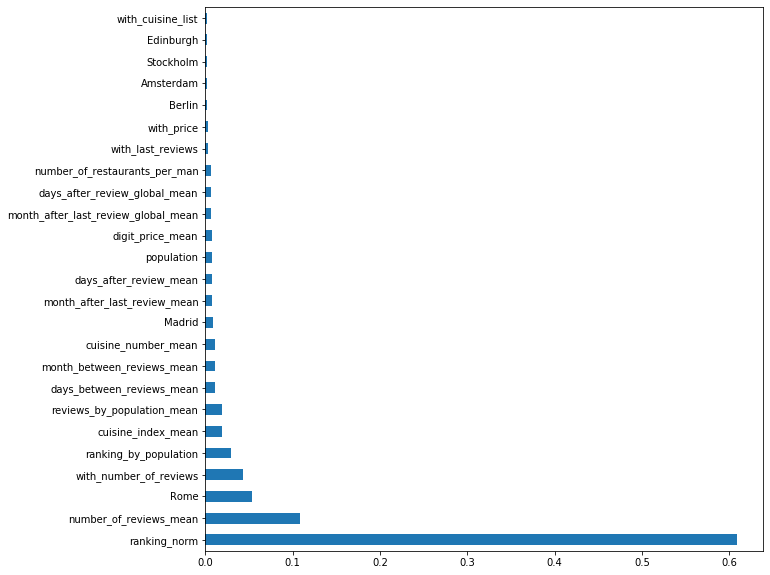

In [252]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')

#### Удаление признаков месяцев иежду отзывами и дней с последнего отзыва не привело к повышению точности модели:(

### Submission

In [255]:
X_test_data = df_kaggle_mean.drop(['rating'], axis = 1)

In [256]:
predict_submission = regr.predict(X_test_data)

In [258]:
predict_submission_ser=pd.Series(predict_submission)

In [271]:
predict_submission_ser_round = predict_submission_ser.apply(y_round)

In [267]:
submission=pd.DataFrame()

In [268]:
submission['Restaurant_id'] = df_kggl['Restaurant_id']

In [272]:
submission['Rating'] = predict_submission_ser_round

In [274]:
submission.to_csv('submission.csv', index=False)
submission.head()

,Restaurant_id,Rating
0,id_0,3.5
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
